# Task_weather

1. День, с минимальной разницей "ощущаемой" и фактической температуры ночью (с указанием разницы в градусах Цельсия) 
2. Максимальную продолжительностью светового дня (считать, как разницу между временем заката и рассвета) за ближайшие 5 дней (включая текущий), с указанием даты.

In [1]:
import requests as req
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import bisect
from datetime import datetime

Для поиска id города, воспользовался ссылкой -> http://api.openweathermap.org/data/2.5/find?q=Moscow,RU&type=like&APPID=83d81f84fdfd4ca7ec7056939d3e867a, где q = Moscow,RU

Очень важно было указать 'RU', иначе на выходе я получал список городов названия которых равны "Moscow", потому что Москва в мире не одна. Также после регистрации на сайт openweathermap.org перешёл в профиль и нашёл свой API key, который также необходим для корректной работы. В моём случае мой API key = 83d81f84fdfd4ca7ec7056939d3e867a  

In [2]:
city = 'Moscow,RU'

In [3]:
city_id = 0

In [4]:
appid = '83d81f84fdfd4ca7ec7056939d3e867a'

In [5]:
try:
    res = req.get("http://api.openweathermap.org/data/2.5/find",
                 params={'q': city, 'type': 'like', 'units': 'metric', 'APPID': appid})
    data = res.json()
    cities = ['{} ({})'.format(d['name'],d['sys']['country'])
             for d in data['list']]
    print("city:", cities)
    city_id = data['list'][0]['id']
    print('city_id=', city_id)
except Exception as e:
    print("Exception (find):", e)
    pass

city: ['Moscow (RU)', 'Moscow (RU)']
city_id= 524901


In [6]:
try:
    res = req.get("http://api.openweathermap.org/data/2.5/weather",
                 params={'id': city_id, 'units': 'metric', 'lang': 'ru', 'APPID': appid})
    data = res.json()
    print("city:", data['name'])
    print("conditions:", data['weather'][0]['description'])
    print("temp:", data['main']['temp'])
    print("temp_min:", data['main']['temp_min'])
    print("temp_max:", data['main']['temp_max'])
    print("feels_like:", data['main']['feels_like'])
except Exception as e:
    print("Exception (weather):", e)
    pass

city: Москва
conditions: небольшой снег
temp: -1.79
temp_min: -3.74
temp_max: -0.87
feels_like: -1.79


In [7]:
print(res.json())

{'coord': {'lon': 37.6156, 'lat': 55.7522}, 'weather': [{'id': 600, 'main': 'Snow', 'description': 'небольшой снег', 'icon': '13n'}], 'base': 'stations', 'main': {'temp': -1.79, 'feels_like': -1.79, 'temp_min': -3.74, 'temp_max': -0.87, 'pressure': 1026, 'humidity': 92, 'sea_level': 1026, 'grnd_level': 1007}, 'visibility': 133, 'wind': {'speed': 0.88, 'deg': 181, 'gust': 1.29}, 'snow': {'1h': 0.45}, 'clouds': {'all': 100}, 'dt': 1639420956, 'sys': {'type': 2, 'id': 2018597, 'country': 'RU', 'sunrise': 1639374680, 'sunset': 1639400178}, 'timezone': 10800, 'id': 524901, 'name': 'Москва', 'cod': 200}


День, с минимальной разницей "ощущаемой" и фактической температуры ночью (с указанием разницы в градусах Цельсия)

In [8]:
try:
    res = req.get("http://api.openweathermap.org/data/2.5/forecast",
                       params={'id': city_id, 'units': 'metric', 'lang': 'ru', 'APPID': appid})
    data = res.json()
    data_time = []
    data_feels_like = []
    data_night = []
    for i in data['list']:
        data_time.append(i['dt_txt'])
        data_feels_like.append(i['main']['feels_like'])
        if re.split(':| ', i['dt_txt'])[-3] in ('00', '03'): # ночь это промежуток времени с 00:00 - 03:00
            data_night.append(i['main']['temp'])
        else: 
            data_night.append(0)
except Exception as e:
    print("Exception (forecast):", e)
    pass

In [9]:
weather = {
    "Дата и время": data_time,
    "Ощущаемая температура": data_feels_like,
    "Температура ночью": data_night
}
weather_df = pd.DataFrame(weather)
weather_df

,Дата и время,Ощущаемая температура,Температура ночью
0,2021-12-13 21:00:00,-1.90,0.00
1,2021-12-14 00:00:00,-2.18,-2.18
2,2021-12-14 03:00:00,-3.93,-3.93
3,2021-12-14 06:00:00,-6.63,0.00
4,2021-12-14 09:00:00,-3.74,0.00
5,2021-12-14 12:00:00,-5.96,0.00
6,2021-12-14 15:00:00,-7.88,0.00
7,2021-12-14 18:00:00,-11.34,0.00
8,2021-12-14 21:00:00,-8.77,0.00
9,2021-12-15 00:00:00,-12.56,-12.56


In [10]:
try:
    res = req.get("http://api.openweathermap.org/data/2.5/forecast",
                       params={'id': city_id, 'units': 'metric', 'lang': 'ru', 'APPID': appid})
    data, d = res.json(), {}
    for i in data['list']:
        if i['dt_txt'].split()[0] not in d: # если текущей даты нет в словаре
            d[i['dt_txt'].split()[0]] = {'feels_like':set(), 'night_temp':set()}  # добавляем новую пару ключ : значение, которая целиком хранится в словаре
        d[i['dt_txt'].split()[0]]['feels_like'].add(i['main']['feels_like']) 
        #для ключа "feels_like" мы в предыдущей строке создали пустой массив, теперь в него добавляем все значения
       
        if re.split(':| ', i['dt_txt'])[-3] in ('00', '03'): # вносим в 'night_temp' только температуру с 00:00-03:00
            d[i['dt_txt'].split()[0]]['night_temp'].add(i['main']['temp'])
            d[i['dt_txt'].split()[0]]['night_temp'].add(i['main']['temp_min'])
            d[i['dt_txt'].split()[0]]['night_temp'].add(i['main']['temp_max'])

        
except Exception as e:
    print("Exception (forecast):", e)
    pass

print(d)

{'2021-12-13': {'feels_like': {-1.9}, 'night_temp': set()}, '2021-12-14': {'feels_like': {-3.93, -11.34, -8.77, -7.88, -6.63, -5.96, -3.74, -2.18}, 'night_temp': {-2.37, -3.93, -2.18}}, '2021-12-15': {'feels_like': {-15.53, -12.56, -10.21, -9.2, -8.12, -6.95, -5.75, -4.25}, 'night_temp': {-12.14, -12.56}}, '2021-12-16': {'feels_like': {-2.15, -2.37, -8.67, -7.93, -5.62, -4.69, -3.96, -2.95}, 'night_temp': {-3.19, -3.38}}, '2021-12-17': {'feels_like': {-0.45, -4.55, -4.86, -2.8, -2.68, -2.98, -4.99, -2.72}, 'night_temp': {-0.45, -0.61}}, '2021-12-18': {'feels_like': {-8.38, -14.76, -11.36, -11.07, -9.83, -8.85, -6.81}, 'night_temp': {-4.68, -2.86}}}


In [11]:
def abs_diff(x, y):
    return abs(x - y)

def find_nearest(sorted_a, y):
    i = bisect.bisect(sorted_a, y)
    return min(
        sorted_a[max(i - 1, 0) : min(i + 1, len(sorted_a))],
        key=lambda z: abs_diff(z, y),
    )

def improvement(x, y, z):
    return abs_diff(x, y) - abs_diff(z, y)


def min_diff(a, b):
    sorted_a = sorted(a)
    nearest = [find_nearest(sorted_a, y) for y in b]
    return sum(map(abs_diff, a, b)) - max(map(improvement, a, b, nearest))

def days_min_diff(d):
    days_min_diff = []
    for i in d:
        if len(d[i]['night_temp']) == 0:
            continue
        days_min_diff.append((min_diff(d[i]['feels_like'], d[i]['night_temp']), i))
    return print("День, с минимальной разницей 'ощущаемой' и фактической температуры ночью: {} \nРазница температур по Цельсию составляет: {}°C".format(min(days_min_diff)[1], round(min(days_min_diff)[0], 2)))    
        
days_min_diff(d)

День, с минимальной разницей 'ощущаемой' и фактической температуры ночью: 2021-12-17 
Разница температур по Цельсию составляет: 0.16°C


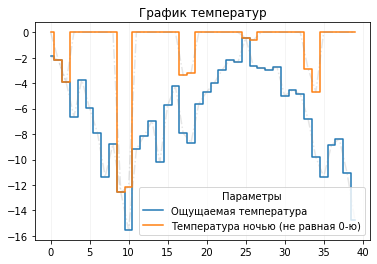

In [12]:
plt.step(np.arange(40), data_feels_like, where='mid', label='Ощущаемая температура')
plt.plot(np.arange(40), data_feels_like, '-.', color='grey', alpha=0.2)

plt.step(np.arange(40), data_night, where='mid', label='Температура ночью (не равная 0-ю)')
plt.plot(np.arange(40), data_night, '-.', color='grey', alpha=0.2)


plt.grid(axis='x', color='0.95')
plt.legend(title='Параметры')
plt.title('График температур')
plt.show()

2. Найти максимальную продолжительностью светового дня (считать, как разницу между временем заката и рассвета) за ближайшие 5 дней (включая текущий), с указанием даты.

In [13]:
res = req.get("https://api.openweathermap.org/data/2.5/onecall", 
              params = {'lat': 55.7522, 'lon': 37.6156, 'exclude': 'hourly', 'APPID': appid})
data = res.json()
print(f"Максимальная продолжительность светого дня \
{datetime.utcfromtimestamp(int(str(i['dt']))).strftime('%Y-%m-%d')} составляет \
{datetime.utcfromtimestamp(int(str(max((i['sunset'] - i['sunrise']) for i in data['daily'])))).strftime('%H:%M:%S')}")


Максимальная продолжительность светого дня 2021-12-18 составляет 07:04:58
